In [1]:
%run ../src/shipproject/imports.py

2021-07-12 12:37:05.811075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-12 12:37:05.811106: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


imports added!


In [2]:
from shipproject.ships_utils import *
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%time d, df = getData()

CPU times: user 6.3 s, sys: 532 ms, total: 6.83 s
Wall time: 7.19 s


In [5]:
%%time
x = np.array(d['data']).astype('uint8')
y = np.array(d['labels']).astype('uint8')


CPU times: user 3.58 s, sys: 189 ms, total: 3.77 s
Wall time: 3.75 s


In [6]:
xx, yy = reshape(x,y)

shipImages = xx[y==1]
notShipImages = xx[y==0]

<h4>following the tutorial from <a href="https://www.tensorflow.org/tutorials/images/data_augmentation">here</a> at option 2- apply the preprocessing to the dataset</h4>

In [7]:
IMG_SIZE = shipImages[0].shape[0]

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomContrast(.8),
    
])

def randBright(img, max_factor=0.5):
    """
    param img- an image from 0 to 255
    param max_factor- percentage offset
    """ 
    factor = (np.random.random()*2*max_factor) - max_factor
    temp = tf.image.adjust_brightness(img, factor)
    temp = tf.clip_by_value(temp, 0, 1)
    return temp

2021-07-12 12:37:56.231954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-12 12:37:56.231993: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-12 12:37:56.232017: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (max): /proc/driver/nvidia/version does not exist
2021-07-12 12:37:56.232225: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    xx, y, test_size=0.2, random_state=0)


In [9]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=.5, random_state=0)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [11]:
it = iter(train_dataset)

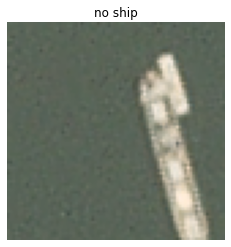

In [13]:
image, label = next(it)
plt.imshow(image)
plt.title("no ship" if label.numpy() == 0 else "ship" )
plt.axis('off');

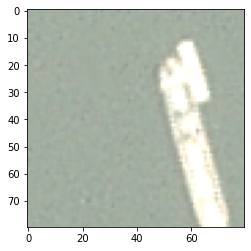

In [16]:
plt.imshow(randBright(image/255))

In this case the prepreprocessing layers will not be exported with the model when you call model.save. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export


In [17]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                   num_parallel_calls=AUTOTUNE)
        ds = ds.map(lambda x, y: (randBright(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

In [18]:
train_ds = prepare(train_dataset, shuffle=True, augment=False)
val_ds = prepare(val_dataset)
test_ds = prepare(test_dataset)

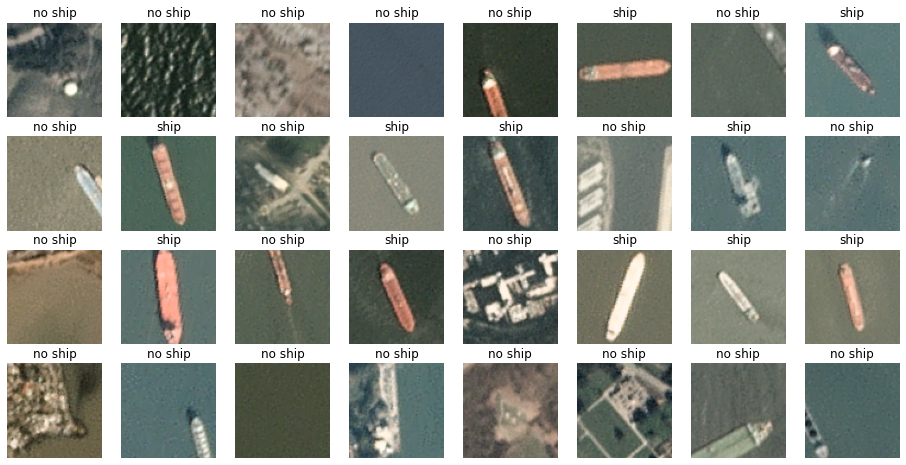

In [20]:
# view some sample images
for images, labels in train_ds.take(1):
    plt.figure(figsize=(16,8))
    plt.tight_layout
    img = image[0]
    row, col = 4, 8
    for e in range(row*col):
        plt.subplot(row, col, e + 1)
        plt.imshow(images[e])
        plt.title("ship" if labels[e]==1 else "no ship")
        plt.axis('off')
        

In [21]:
# nothing special
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [22]:
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
             metrics='accuracy')

In [23]:
# no augmentation in train_ds
epochs=10
no_aug_history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
100/100 [==============================] - 7s 69ms/step - loss: 0.3121 - accuracy: 0.8591 - val_loss: 0.2319 - val_accuracy: 0.9025
Epoch 2/10
100/100 [==============================] - 7s 68ms/step - loss: 0.1682 - accuracy: 0.9344 - val_loss: 0.1728 - val_accuracy: 0.9275
Epoch 3/10
100/100 [==============================] - 7s 68ms/step - loss: 0.1474 - accuracy: 0.9431 - val_loss: 0.1512 - val_accuracy: 0.9300
Epoch 4/10
100/100 [==============================] - 7s 69ms/step - loss: 0.1022 - accuracy: 0.9597 - val_loss: 0.2514 - val_accuracy: 0.9125
Epoch 5/10
100/100 [==============================] - 7s 74ms/step - loss: 0.0942 - accuracy: 0.9650 - val_loss: 0.0960 - val_accuracy: 0.9775
Epoch 6/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0482 - accuracy: 0.9847 - val_loss: 0.1012 - val_accuracy: 0.9700
Epoch 7/10
100/100 [==============================] - 7s 71ms/step - loss: 0.0388 - accuracy: 0.9869 - val_loss: 0.1006 - val_accuracy: 0.9675

get images and labels separatly for prediction and confusion matrix

In [24]:
loss, acc = model.evaluate(test_ds)

13/13 [==============================] - 0s 19ms/step - loss: 0.0901 - accuracy: 0.9775


In [25]:
# now try it with augmentation
train_ds_aug = prepare(train_dataset, shuffle=True, augment=True)
# val_ds = prepare(val_dataset)
# test_ds = prepare(test_dataset)
model_aug = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])
model_aug.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
             metrics='accuracy')
aug_history = model_aug.fit(train_ds_aug, validation_data=val_ds, epochs=10)

Epoch 1/10
100/100 [==============================] - 7s 70ms/step - loss: 0.3819 - accuracy: 0.8316 - val_loss: 0.2414 - val_accuracy: 0.9000
Epoch 2/10
100/100 [==============================] - 7s 72ms/step - loss: 0.2679 - accuracy: 0.8900 - val_loss: 0.3091 - val_accuracy: 0.8800
Epoch 3/10
100/100 [==============================] - 7s 73ms/step - loss: 0.2050 - accuracy: 0.9153 - val_loss: 0.2327 - val_accuracy: 0.9075
Epoch 4/10
100/100 [==============================] - 8s 82ms/step - loss: 0.1860 - accuracy: 0.9278 - val_loss: 0.1754 - val_accuracy: 0.9275
Epoch 5/10
100/100 [==============================] - 9s 84ms/step - loss: 0.1542 - accuracy: 0.9400 - val_loss: 0.1242 - val_accuracy: 0.9650
Epoch 6/10
100/100 [==============================] - 8s 76ms/step - loss: 0.1098 - accuracy: 0.9603 - val_loss: 0.1251 - val_accuracy: 0.9650
Epoch 7/10
100/100 [==============================] - 8s 82ms/step - loss: 0.1064 - accuracy: 0.9578 - val_loss: 0.1029 - val_accuracy: 0.9650

In [26]:
loss, acc = model_aug.evaluate(test_ds)

13/13 [==============================] - 0s 18ms/step - loss: 0.0717 - accuracy: 0.9775


In [27]:
simple_data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      
])

In [28]:
def prepare_simple(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    if augment:
        ds = ds.map(lambda x, y: (simple_data_augmentation(x, training=True), y),
                   num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

In [29]:
# now try it with simple augmentation
train_ds_simple_aug = prepare_simple(train_dataset, shuffle=True, augment=True)
# val_ds = prepare(val_dataset)
# test_ds = prepare(test_dataset)
model_simple_aug = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])
model_simple_aug.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
             metrics='accuracy')
simple_aug_history = model_simple_aug.fit(train_ds_simple_aug, validation_data=val_ds, epochs=10)

Epoch 1/10
100/100 [==============================] - 7s 69ms/step - loss: 0.3430 - accuracy: 0.8494 - val_loss: 0.2596 - val_accuracy: 0.8800
Epoch 2/10
100/100 [==============================] - 7s 72ms/step - loss: 0.2121 - accuracy: 0.9125 - val_loss: 0.2359 - val_accuracy: 0.8975
Epoch 3/10
100/100 [==============================] - 7s 73ms/step - loss: 0.1748 - accuracy: 0.9316 - val_loss: 0.1563 - val_accuracy: 0.9425
Epoch 4/10
100/100 [==============================] - 7s 73ms/step - loss: 0.1340 - accuracy: 0.9478 - val_loss: 0.1729 - val_accuracy: 0.9250
Epoch 5/10
100/100 [==============================] - 7s 73ms/step - loss: 0.0974 - accuracy: 0.9625 - val_loss: 0.1170 - val_accuracy: 0.9600
Epoch 6/10
100/100 [==============================] - 7s 73ms/step - loss: 0.0614 - accuracy: 0.9775 - val_loss: 0.0766 - val_accuracy: 0.9750
Epoch 7/10
100/100 [==============================] - 8s 76ms/step - loss: 0.0498 - accuracy: 0.9809 - val_loss: 0.0789 - val_accuracy: 0.9875

## maybe a little better
The images are very simple and there are thousands of them so maybe that is enough. That is why a sophisticated model is not needed as the task is simple enough since the images are simple. Maybe?

In [30]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [31]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass


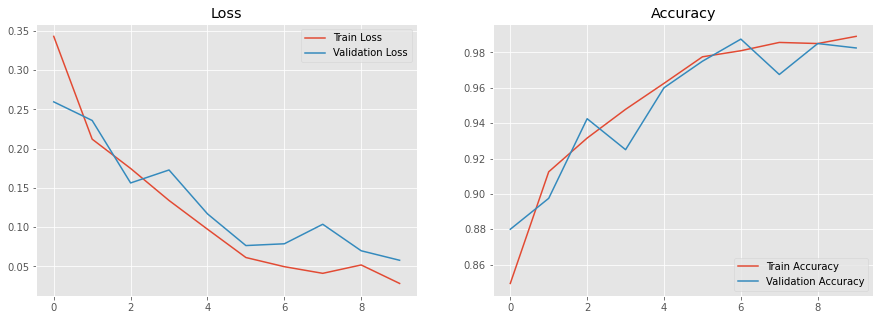

In [32]:
show_final_history(simple_aug_history)

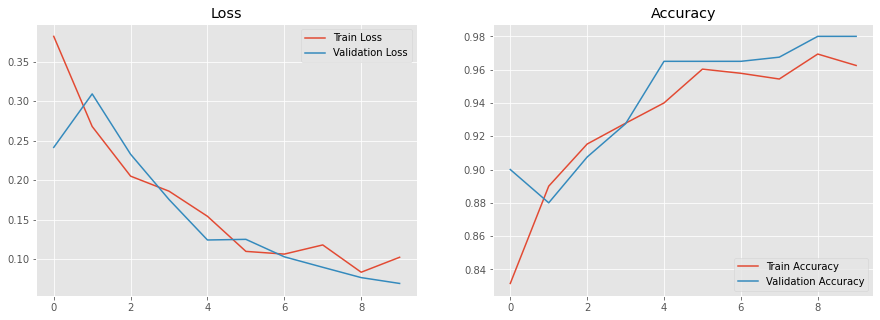

In [33]:
show_final_history(aug_history)

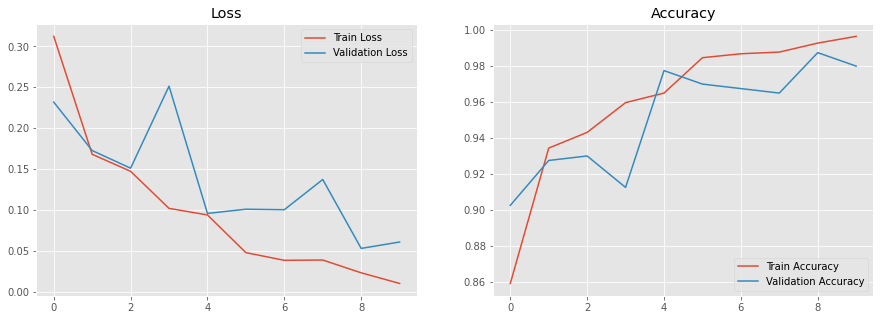

In [34]:
show_final_history(no_aug_history)

In [85]:
preds = model_simple_aug.predict(x_test)
preds = np.array([1 if each == 1.0 else 0 for each in list(preds.squeeze())])
preds.shape

(400,)

In [86]:
cor = preds == y_test
cor = list(cor)

In [87]:
incorrect_idx = []
for i, each in enumerate(cor):
    if  not each:
        incorrect_idx.append(i)

In [88]:
incorrect_idx

[21, 29, 48, 71, 106, 179, 181, 186, 201, 203, 222, 371]

### These are the ones the model predicted incorrectly
incorrect predictions are included in the titles

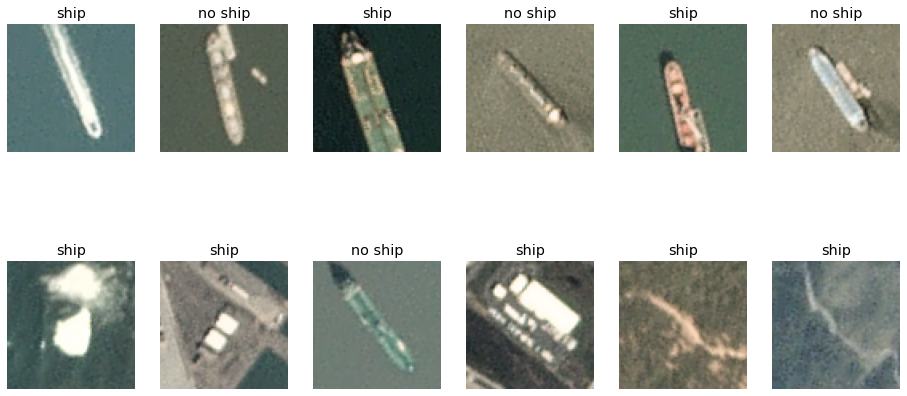

In [84]:
plt.figure(figsize=(16,8))
plt.tight_layout
row, col = 2,6
for e in range(row*col):
    plt.subplot(row, col, e + 1)
    idx = incorrect_idx[e]
    img = x_test[idx]/255
    plt.imshow(img)
    plt.title("ship" if preds[idx]==1 else "no ship")
    plt.axis('off')

In [80]:
x_test.shape

(400, 80, 80, 3)

In [82]:
zz = x_test[0]
zz.shape, np.max(zz)

((80, 80, 3), 243)

In [73]:
acc = np.sum(preds == y_test)/preds.shape[0]
acc

0.97

### so on the test set we get 97% correct  

### Testing what some of the augmentqtion might look like

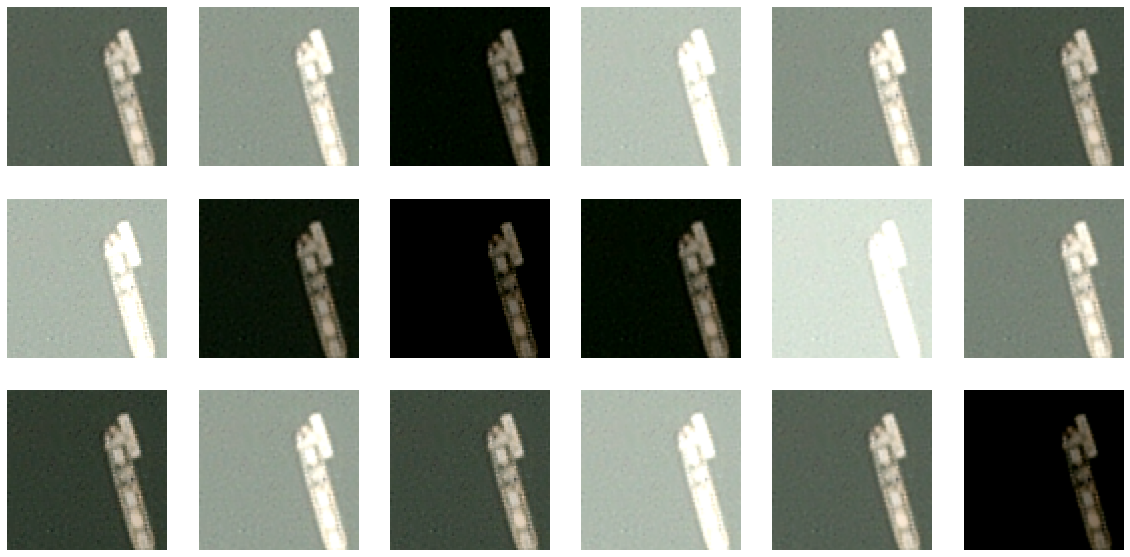

In [95]:
plt.figure(figsize=(20,10))
for i in range (18):
    ii = randBright(image/255)
    plt.subplot(3,6,i+1)
    plt.imshow(ii)
    plt.axis('off')
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

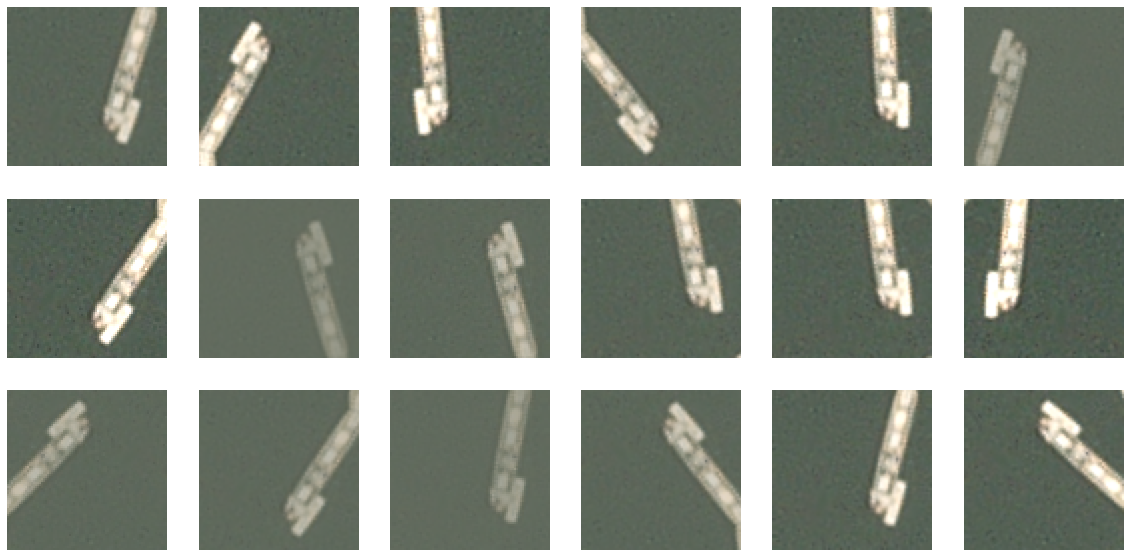

In [103]:
plt.figure(figsize=(20,10))
for i in range (18):
    ii = data_augmentation(tf.expand_dims(image/255,0))
#     np.clip(ii, 0, 1)
    plt.subplot(3,6,i+1)
    plt.imshow(ii[0])
    plt.axis('off')
    